In [1]:
import celeba_dataset as ds 
import skin_seg as ss

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
celebA_data = ds.image_dataset(filepath="/home/sasha/Desktop/data/celebA_img_norm_mask_light.h5", 
                                transform=True)

(48232, 64, 64)


(48232, 64, 64)
(64, 64, 3) 0.47459123 1.0 0.078431375


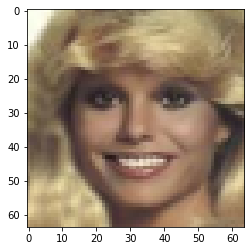

1.0 0.0


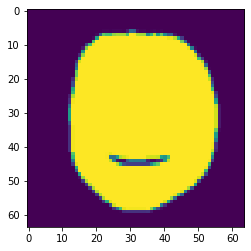

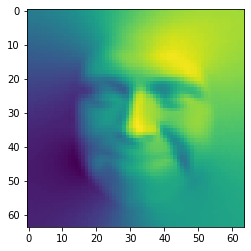

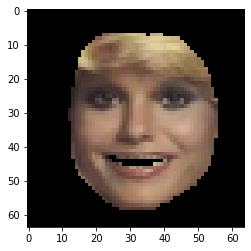

In [3]:
print(celebA_data.mask.shape)
i = 5
batch = celebA_data.get_batch()
imgs, masks, shadings = batch
img = np.transpose(imgs[i], (1,2,0))
print(img.shape, np.mean(img), np.max(img), np.min(img))
plt.imshow(img)
plt.show()
print(np.max(masks[i]), np.min(masks[i]))
plt.imshow(masks[i])
plt.show()
plt.imshow(shadings[i])
plt.show()
mask_bool = masks[i] > 0.5
mask_bool = np.reshape(mask_bool, mask_bool.shape + (1,))
plt.imshow(np.multiply(mask_bool, img))
plt.show()

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [5]:
model = ss.ConvAutoEncoderArrayDecoder(num_decoders=1)
model.to(device)
# print(model)
# model.parameters()

ConvAutoEncoderArrayDecoder(
  (encoder): ConvAutoEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchNorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchNorm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

In [6]:
# Loss function
criterion = torch.nn.BCEWithLogitsLoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [7]:
#Epochs
n_epochs = 4
batch = 1

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    batch = 1
    #Training
    for data in celebA_data:
        images, mask, _ = data
        
        images = torch.tensor(images)
        images = images.to(device)
        mask = torch.tensor(mask)
        mask = torch.reshape(mask, shape=(mask.shape[0], 1) + mask.shape[1:3])
        mask = mask.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs[0], mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        print("\rBatch: " + str(batch) + "/" + str(celebA_data.num_images//celebA_data.batch_size) + " - Loss: " + str(loss.item()), end='')
        batch += 1
          
    train_loss = train_loss/len(celebA_data)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Batch: 752/753 - Loss: 0.056717462837696075Epoch: 1 	Training Loss: 0.104762
Batch: 753/753 - Loss: 0.04961547255516052Epoch: 2 	Training Loss: 0.052744
Batch: 753/753 - Loss: 0.04325423017144203Epoch: 3 	Training Loss: 0.046454
Batch: 753/753 - Loss: 0.05415935441851616Epoch: 4 	Training Loss: 0.043271
Batch: 32/753 - Loss: 0.0409887321293354

KeyboardInterrupt: 

torch.Size([64, 3, 64, 64])
(64, 64, 3)
0.30211625
/home/sasha/.local/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


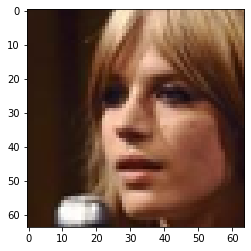

(64, 64, 1) 0.4526919 0.999995 9.244457e-05


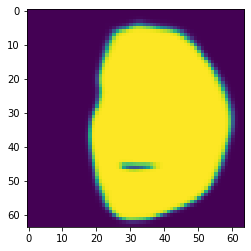

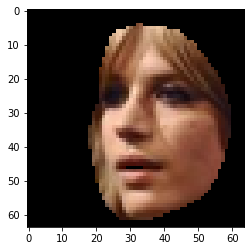

(64, 64, 3)
0.37622166


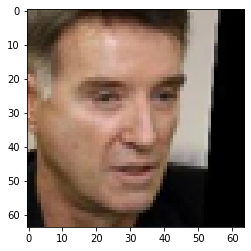

(64, 64, 1) 0.44357216 0.99999774 7.5389915e-05


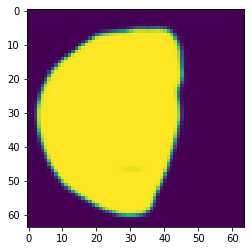

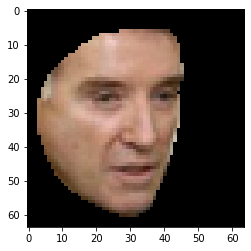

(64, 64, 3)
0.53780925


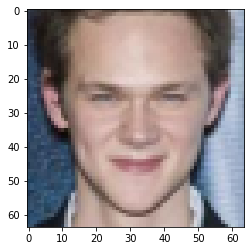

(64, 64, 1) 0.41981828 0.99999774 4.849035e-05


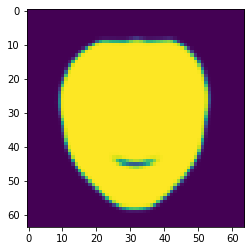

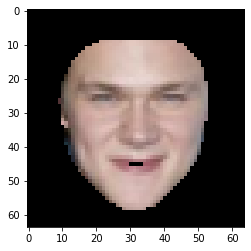

(64, 64, 3)
0.40868664


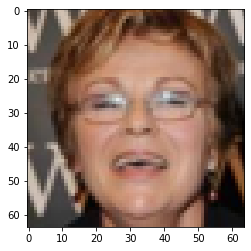

(64, 64, 1) 0.4345131 0.9999901 8.1528415e-05


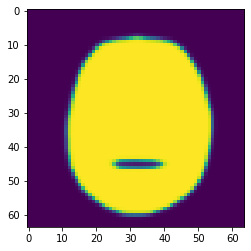

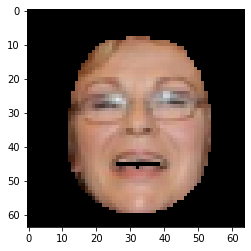

(64, 64, 3)
0.42570624


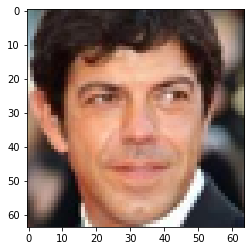

(64, 64, 1) 0.45910496 0.9999981 7.745866e-05


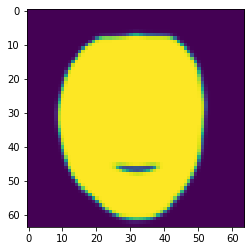

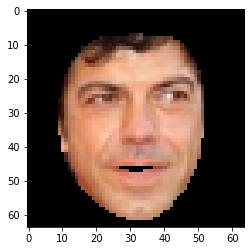

In [8]:
sample = celebA_data.images[0:64]
sample_img = torch.tensor(sample)
sample_img = sample_img.to(device)
print(sample_img.shape)
output, _ = model(sample_img)
# output = torch.nn.functional.sigmoid(output)
output = np.array([torch.nn.functional.sigmoid(put.cpu().detach()).numpy() for put in output])
# output.cpu().detach()

for i in range(5):
    img = np.transpose(sample[i], (1,2,0))
    print(img.shape)
    print(np.mean(img)) 
    plt.imshow(img)
    plt.show()

    # output_img = np.array([put.cpu().detach().numpy() for put in output[i]])
    output_img = np.transpose(output[0][i], (1,2,0))
    print(output_img.shape, np.mean(output_img), np.max(output_img), np.min(output_img))
    plt.imshow(output_img)
    plt.show()

    mask_bool = output_img > 0.4
    plt.imshow(np.multiply(mask_bool, img))
    plt.show()

In [10]:
torch.save(model.state_dict(), "models/skin_seg")

In [11]:
model2 = ss.ConvAutoEncoderArrayDecoder(num_decoders=1)
model2.load_state_dict(torch.load("models/skin_seg"))
model2.eval()
model2.to(device)

ConvAutoEncoderArrayDecoder(
  (encoder): ConvAutoEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchNorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchNorm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, a